# Life Cycle Assessment (LCA) <a class="anchor" id="top"></a>

* **Prepared by:**

    - [Yalin Li](https://qsdsan.readthedocs.io/en/latest/authors/Yalin_Li.html)

* **Covered topics:**

    - [1. ImpactIndicator](#s1)
    - [2. ImpactItem and StreamImpactItem](#s2)
    - [3. Construction, Transportation, and other activities](#s3)
    - [4. LCA](#s4)

- **Video demo:**

    - [Tori Morgan](https://qsdsan.readthedocs.io/en/latest/authors/Tori_Morgan.html)

To run tutorials in your browser, go to this [Binder page](https://mybinder.org/v2/gh/QSD-Group/QSDsan/main?filepath=%2Fdocs%2Fsource%2Ftutorials).

You can also watch a video demo on [YouTube](https://youtu.be/ULmFYO8nTrM) (subscriptions & likes appreciated!).

In [1]:
import qsdsan as qs
print(f'This tutorial was made with qsdsan v{qs.__version__}.')

This tutorial was made with qsdsan v1.2.0.


## 1. `ImpactIndicator` <a class="anchor" id="s1"></a>
LCA is a bit more complicated than TEA since there are multiple indicators we can choose from and we might want to see the life cycle impact assessment (LCIA) results for multiple indicators. Therefore, `qsdsan` implements multiple new classes for LCA, and the one to start with is the `ImpactIndicator` class.

In [2]:
qs.ImpactIndicator?

When initializing a new `ImpactIndicator` instance, `ID` and `unit` are the most important attributes, `alias` is for convenience, and `method`, `category`, and `description` are mostly for record purpose.

In [3]:
# Assume we are mostly interested in global warming potential and fossil energy consumption
GWP = qs.ImpactIndicator(ID='GlobalWarming', method='TRACI', category='environmental impact', unit='kg CO2-eq',
                         description='Effect of climate change measured as global warming potential.')
FEC = qs.ImpactIndicator(ID='FossilEnergyConsumption', alias='FEC', unit='MJ')

In [4]:
GWP.show()

ImpactIndicator: GlobalWarming as kg CO2-eq
 Alias      : None
 Method     : TRACI
 Category   : environmental impact
 Description: Effect of climate change ...


In [5]:
# You can set alias for indicators (you can also set it during initiation as in the example above for FEC)
GWP.alias = 'GWP'
GWP.show()

ImpactIndicator: GlobalWarming as kg CO2-eq
 Alias      : GWP
 Method     : TRACI
 Category   : environmental impact
 Description: Effect of climate change ...


In [6]:
FEC.show()

ImpactIndicator: FossilEnergyConsumption as MJ
 Alias      : FEC
 Method     : None
 Category   : None
 Description: None


In [7]:
# You can also retrieve an `ImpactIndicator` through its ID or alias
qs.ImpactIndicator.get_indicator('FEC').show()

ImpactIndicator: FossilEnergyConsumption as MJ
 Alias      : FEC
 Method     : None
 Category   : None
 Description: None


In [8]:
# Or get all defined impact indicators
qs.ImpactIndicator.get_all_indicators()

{'GlobalWarming': <ImpactIndicator: GlobalWarming>,
 'FossilEnergyConsumption': <ImpactIndicator: FossilEnergyConsumption>}

[Back to top](#top)

## 2. `ImpactItem` and `StreamImpactItem` <a class="anchor" id="s2"></a>
Once you have impact indicators, you can start adding impact items and specifying the environmental impacts for each funcitonal unit of the item.

### 2.1. `ImpactItem`
For example, assume we need some electricity, and that to generate 1 kWh of electricity, 0.15 kg of CO<sub>2</sub> is emitted, and it uses 4500 kJ of fossil energy.

In [9]:
qs.ImpactItem?

In [10]:
electricity = qs.ImpactItem('electricity', functional_unit='kWh')

In [11]:
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : None USD
ImpactIndicators:
 None


---

### Note
`ImpactItem` also has a `price` attribute that allows you to put in the price for the impact item, but it is mainly used for construction items and will be included in unit CAPEX, if you want to account for the cost of electricity, you should set the power utility usage of the unit and modify `qsdsan.PowerUtility.price`.

---

In [12]:
# We can add characterization factors (CFs) for the two impact indicators GWP and FEC
electricity.add_indicator(GWP, 0.25)
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : None USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                      0.25


In [13]:
# If you provide unit when adding the CF value, qsdsan will do the unit conversion
electricity.add_indicator(FEC, 4500, 'kJ')
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : None USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                         0.25
FossilEnergyConsumption (MJ)                       4.5


In [14]:
# If you later want to change this value, you can also do it
electricity.CFs['FossilEnergyConsumption'] = 50
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : None USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                         0.25
FossilEnergyConsumption (MJ)                        50


In [15]:
# Similar to `ImpactIndicator`, you can retrieve one `ImpactItem` by its ID,
# or see all defined impact items
qs.ImpactItem.get_item('electricity').show()
qs.ImpactItem.get_all_items()

ImpactItem      : electricity [per kWh]
Price           : None USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                         0.25
FossilEnergyConsumption (MJ)                        50


{'electricity': <ImpactItem: electricity>}

### 2.2. `StreamImpactItem`
A special case of impact items are ones related to material inputs and generated wastes/emissions, and it's more convenient to use `StreamImpactItem` (a subclass of `ImpactItem`).

A big perk of using `StreamImpactItem` is that you can link it to a particular stream, therefore after you simulate the system, quantity of this item will be automatically updated

In [16]:
cmps = qs.Components.load_default()
qs.set_thermo(cmps)
ww = qs.WasteStream.codbased_inf_model(flow_tot=1000)

In [17]:
# For example, let's assume we want to account for the emissions with the wastewater
# note that indicator CFs can be added via a number of a tuple of (quantity, unit)
ww_item = qs.StreamImpactItem(linked_stream=ww, GWP=1, FEC=(100, 'kJ'))
ww_item.show()

StreamImpactItem: ws1_item [per kg]
Linked to       : ws1
Price           : None USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                            1
FossilEnergyConsumption (MJ)                       0.1


In [18]:
# The price of the impact item will be linked to the price of the stream
ww.price = 0.2
ww_item.show()

StreamImpactItem: ws1_item [per kg]
Linked to       : ws1
Price           : 0.2 USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                            1
FossilEnergyConsumption (MJ)                       0.1


In [19]:
# And you would get an error if you tried to set the price of the impact item
# ww_item.price = 0.1

In [20]:
# In designing the system, you may need multiple items of the same settings,
# for example you can have many wastewater streams,
# you can use the `copy` method and use `set_as_source` to set
# the original impact item as the source
# (so that if you need to update something, you can just update one impact item)
ww2 = qs.WasteStream.bodbased_inf_model(flow_tot=200)
ww_item2 = ww_item.copy(stream=ww2, set_as_source=True)
ww_item2.show()

StreamImpactItem: ws2_item [per kg]
Linked to       : ws2
Source          : ws1_item
Price           : None USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                            1
FossilEnergyConsumption (MJ)                       0.1


In [21]:
# Updating the CF values of either of the impact items would affect both
ww_item2.CFs['FossilEnergyConsumption'] = 1
print(ww_item.CFs['FossilEnergyConsumption'])
print(ww_item2.CFs['FossilEnergyConsumption'])

0.1
0.1


In [22]:
# This works for ImpactItem objects other than StreamImpactItem as well
e2 = electricity.copy(new_ID='copied_electricity', set_as_source=True)
e2.show()

ImpactItem      : copied_electricity [per kWh]
Source          : electricity
Price           : None USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                         0.25
FossilEnergyConsumption (MJ)                        50


[Back to top](#top)

## 3. `Construction`, `Transportation`, and other activities <a class="anchor" id="s3"></a>
With these defined impact items, we can now account for impacts with construction, transportation, and other activities during LCA.

### 3.1. `Construction`
The `Construction` class is used to include impacts associated with the construction of a certain unit operation and is stored in the `SanUnit.construction`.

For example, in the bwasise system, the pit latrine has several construction activities, for illustration purpose (and because `PitLatrine` requires setting multiple influents and I'm too lazy...), let's just check the established units/systems in [Trimmer et al.](https://doi.org/10.1021/acs.est.0c03296)

In [23]:
from exposan import bwaise as bw
bw.load()
bw.A2.construction

/Users/yalinli_cabbi/opt/anaconda3/envs/demo/lib/python3.8/site-packages/qsdsan/_impact_indicator.py:27: UserWarning: The impact indicator "GlobalWarming" already exists and has a different description (Effect of climate change measured as global warming potential.) than the provided one (Potential global warming based on chemical's radiative forcing and lifetime).
  warn (f'The impact indicator "{ID}" already exists '


(<Construction: bwA_A2_cement>,
 <Construction: bwA_A2_sand>,
 <Construction: bwA_A2_gravel>,
 <Construction: bwA_A2_brick>,
 <Construction: bwA_A2_liner>,
 <Construction: bwA_A2_steel>,
 <Construction: bwA_A2_wood>,
 <Construction: bwA_A2_excavation>)

In [24]:
Cement = bw.A2.construction[0]
Cement.show()

Construction : bwA_A2_cement
Impact item  : Cement
Lifetime     : None yr
Quantity     : 2.00E+07 kg
Total cost   : None USD
Total impacts:
                           Impacts
GlobalWarming (kg CO2-eq) 2.16e+07


In [25]:
# Each Construction activity is linked with an ImpactItem
Cement.item.show()

ImpactItem      : Cement [per kg]
Price           : None USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                      1.08


In [26]:
# The total impact and cost is calculated through the quantity of the activity
# and the price/CFs of the its impact item
Cement.quantity

19979181.25

In [27]:
Cement.impacts['GlobalWarming'] == Cement.item.CFs['GlobalWarming']*Cement.quantity

True

### 3.2. `Transportation`
Similar to `Construction`, each `Transportation` object is linked to an `ImpactItem`, but it calculates the total impacts by taking into the transportation load, distance, and interval.

In [28]:
# For example, suppose we want to take calculate impacts associated with cars
# First to make an ImpactItem for this
car_item = qs.ImpactItem('car_item', functional_unit='kg*km', GWP=10)
car_item.show()

ImpactItem      : car_item [per kg*km]
Price           : None USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                        10


In [29]:
# Then to add the Transportation activity
# I'm using a weird unit for fun
car_trans = qs.Transportation(item='car_item', load_type='mass', load=5000, load_unit='kg',
                             distance=5e6, distance_unit='cm', interval=20, interval_unit='hr')
car_trans.show()

Transportation: Trans1
Impact item   : car_item [per trip]
Load          : 5000 kg
Distance      : 50.0 km
Interval      : 20 hr
Total cost    : None USD
Total impacts :
                           Impacts
GlobalWarming (kg CO2-eq)  2.5e+06


**Note:** Here the imapcts are calculated for each trip, in LCA, `qsdsan` will calculate how many trips are made in the entire lifetime of the system using `interval`.

In [30]:
# In a `SanUnit`, Transportation activities are stored in `SanUnit.transportation`
bw.A3.transportation

(<Transportation: bwA_A3_total_truck>,)

In [31]:
bw.A3.transportation[0].show()

Transportation: bwA_A3_total_truck
Impact item   : Trucking [per trip]
Load          : 9.86E+07 kg
Distance      : 5 km
Interval      : 7008 hr
Total cost    : None USD
Total impacts :
                           Impacts
GlobalWarming (kg CO2-eq) 9.57e+04


### 3.3. Other activities
If there are additional activities that are not covered by materials, construction, and transportation (e.g., electricity), you can add it when making the `LCA` object (example in the `LCA` section below).

[Back to top](#top)

## 4. `LCA` <a class="anchor" id="s4"></a>
Finally, we can use the `LCA` class to perform LCA. Like `TEA`, each instance of `LCA` is linked with a `System` object. 

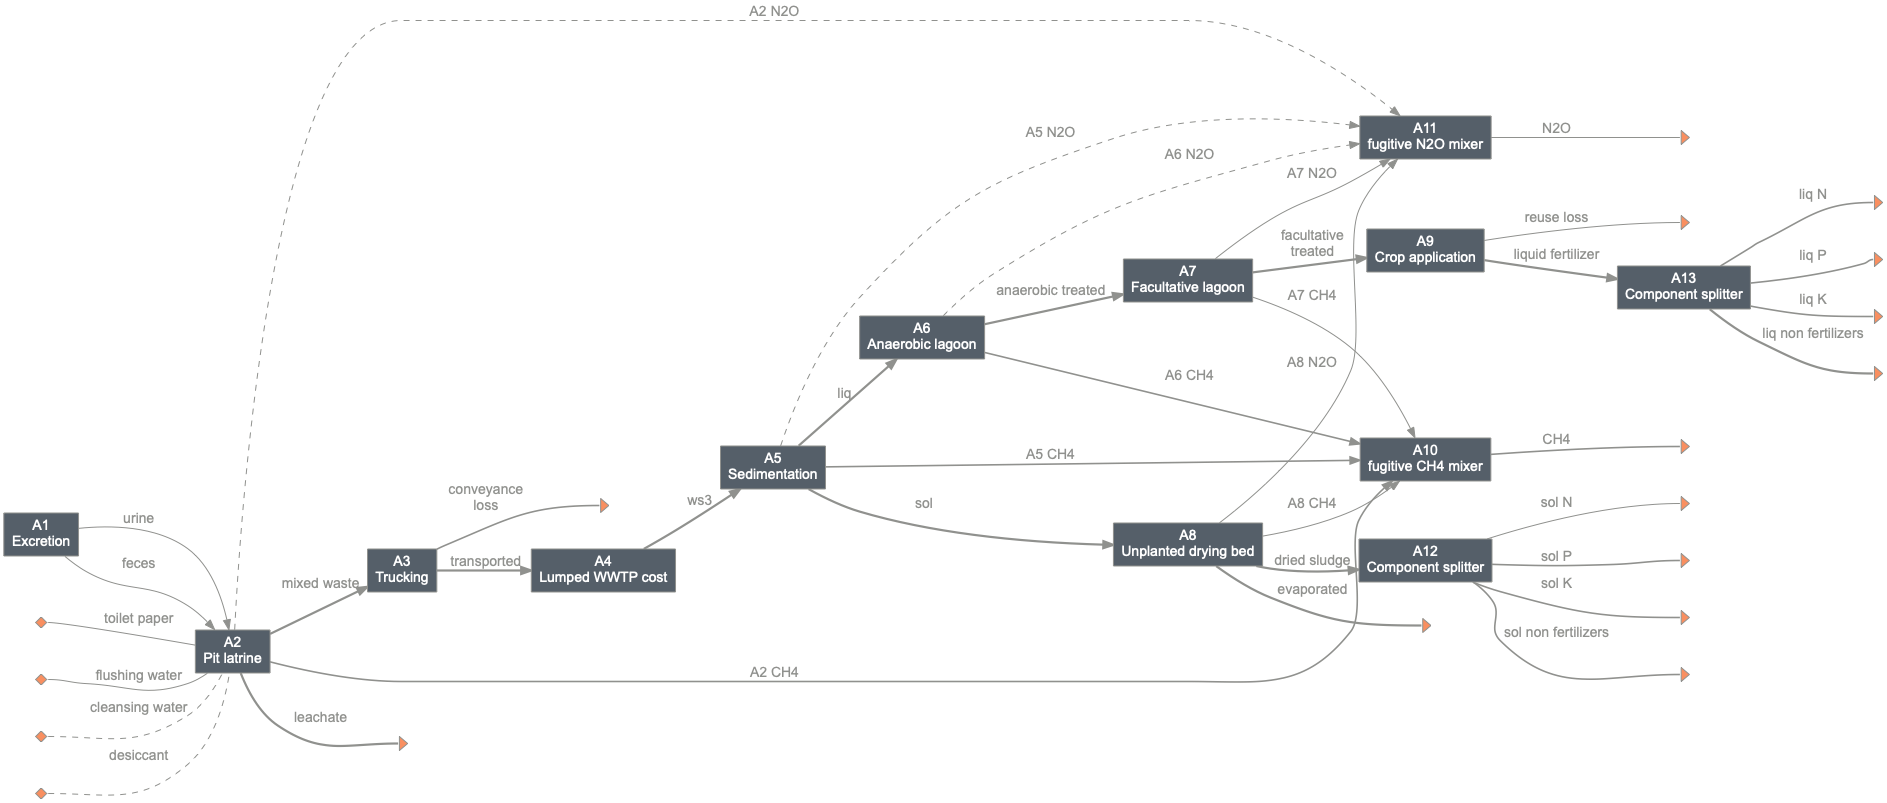

In [32]:
sys = bw.sysA
# You can double-click the diagram to enlarge it
sys.diagram()

In [33]:
# Note that here electricity is the additional impact activity that is not covered by
# construction, transportation, or material inputs/waste emissions,
# so you'll want to add it when initializing the `LCA` instance
lca = qs.LCA(system=sys, lifetime=8, lifetime_unit='yr', electricity=1e6)
lca.show()

LCA: sysA (lifetime 8 yr)
Impacts:
                              Construction  Transportation   Stream  Others    Total
GlobalWarming (kg CO2-eq)         3.13e+07        9.57e+05 1.82e+08 2.5e+05 2.14e+08
FossilEnergyConsumption (MJ)             0               0        0   5e+07    5e+07


In [34]:
# If impacts from those other activities change with simulation,
# you can add them as functions
a = 100
b = 1000
lca = qs.LCA(system=sys, lifetime=8, lifetime_unit='yr', electricity=lambda: a+b)
lca.show()

LCA: sysA (lifetime 8 yr)
Impacts:
                              Construction  Transportation   Stream  Others    Total
GlobalWarming (kg CO2-eq)         3.13e+07        9.57e+05 1.82e+08     275 2.14e+08
FossilEnergyConsumption (MJ)             0               0        0 5.5e+04  5.5e+04


In [35]:
# Note the updates in FossilEnergyConsumption values
a = 100000
lca.show()

LCA: sysA (lifetime 8 yr)
Impacts:
                              Construction  Transportation   Stream   Others    Total
GlobalWarming (kg CO2-eq)         3.13e+07        9.57e+05 1.82e+08 2.52e+04 2.14e+08
FossilEnergyConsumption (MJ)             0               0        0 5.05e+06 5.05e+06


In [36]:
# We can also get a more detailed break-down for a specific category
# Note that we need to redefine lca as the electricity 
table = lca.get_impact_table('Construction')
print(table['GlobalWarming [kg CO2-eq]'])

Construction     SanUnit
Brick [kg]       A2        1.81e+06
                 Total     1.81e+06
Cement [kg]      A2        2.16e+07
                 Total     2.16e+07
Concrete [m3]    A5         1.3e+05
                 A8        1.82e+06
                 Total     1.95e+06
Excavation [m3]  A2        5.53e+04
                 A6        7.38e+03
                 A7        1.22e+04
                 Total     7.49e+04
Gravel [kg]      A2        5.48e+05
                 Total     5.48e+05
Plastic [kg]     A2        5.67e+05
                 A6        8.94e+03
                 A7        2.26e+04
                 Total     5.98e+05
Sand [kg]        A2        1.09e+06
                 Total     1.09e+06
Steel [kg]       A2        2.44e+06
                 A5        9.77e+03
                 A8        1.77e+05
                 Total     2.63e+06
Wood [m3]        A2        1.07e+06
                 Total     1.07e+06
Sum              All       3.13e+07
Name: GlobalWarming [kg CO2-eq], dtype:

In [37]:
# For streams, you can specify kind to be 'all', 'direct_emission', or 'offset'
lca.get_stream_impacts(kind='all')

{'GlobalWarming': 181865072.33622834, 'FossilEnergyConsumption': 0.0}

In [38]:
print(lca.get_stream_impacts(kind='direct_emission'))
print(lca.get_stream_impacts(kind='offset'))
print(lca.get_stream_impacts(kind='direct_emission')['GlobalWarming']+lca.get_stream_impacts(kind='offset')['GlobalWarming'])

{'GlobalWarming': 192768185.77699113, 'FossilEnergyConsumption': 0.0}
{'GlobalWarming': -10903113.440762803, 'FossilEnergyConsumption': 0.0}
181865072.3362283


In [39]:
# You can also normalize the impacts to a certain stream,
# the default method is to allocate by mass
lca.get_allocated_impacts(bw.A13.outs)

{'liq_N': {'GlobalWarming': 239045.69098363552,
  'FossilEnergyConsumption': 5405.159839204847},
 'liq_P': {'GlobalWarming': 99558.51411251294,
  'FossilEnergyConsumption': 2251.158261491955},
 'liq_K': {'GlobalWarming': 569984.4814168809,
  'FossilEnergyConsumption': 12888.152115385481},
 'liq_non_fertilizers': {'GlobalWarming': 222429994.3302933,
  'FossilEnergyConsumption': 5029455.529783918}}

In [40]:
lca.get_allocated_impacts(bw.A13.outs, allocate_by='energy')

{'liq_N': {'GlobalWarming': 0.0, 'FossilEnergyConsumption': 0.0},
 'liq_P': {'GlobalWarming': 223338583.01680633,
  'FossilEnergyConsumption': 5050000.0},
 'liq_K': {'GlobalWarming': 0.0, 'FossilEnergyConsumption': 0.0},
 'liq_non_fertilizers': {'GlobalWarming': 0.0, 'FossilEnergyConsumption': 0.0}}

In [41]:
sum(i['GlobalWarming'] for i in lca.get_allocated_impacts(bw.A13.outs).values())

223338583.01680633

In [42]:
# You can also look at all impacts associtated with a certain unit
lca.get_unit_impacts(bw.A2)

/Users/yalinli_cabbi/opt/anaconda3/envs/demo/lib/python3.8/site-packages/qsdsan/_sanstream.py:419: UserWarning: The property `impact_item` has been changed to `stream_impact_item`, please use `stream_impact_item` instead.
  warn('The property `impact_item` has been changed to `stream_impact_item`, '


{'GlobalWarming': 111653458.83813477, 'FossilEnergyConsumption': 5050000.0}

In [43]:
# Finally, you can export all the details as an Excel file
# lca.save_report('lca.xlsx')

[Back to top](#top)